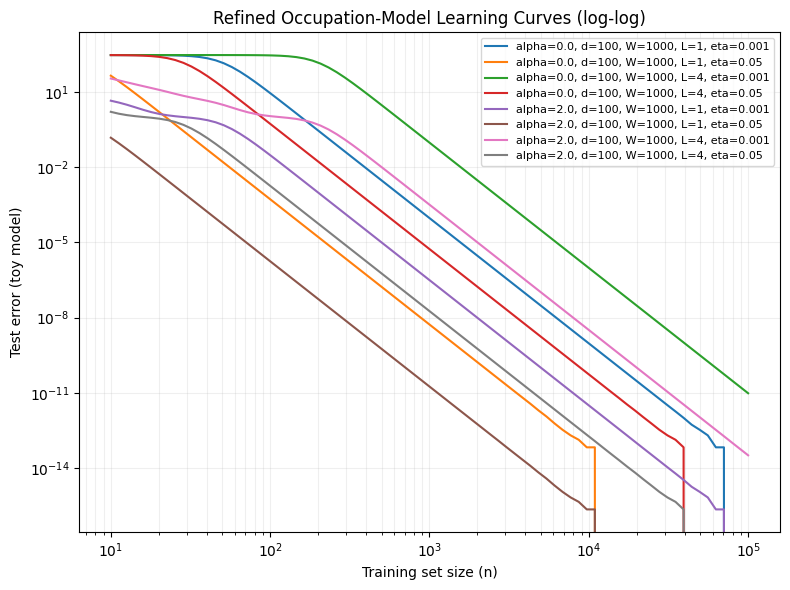

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def occupation_function(n, n_k, beta=5.0):
    """
    Smooth 'step' function on a log scale:
      occ(n) ~ 0 if n << n_k
      occ(n) ~ 1 if n >> n_k
    Beta controls the sharpness of the transition.
    """
    return 1.0 / (1.0 + np.exp(-beta * (np.log(n) - np.log(n_k))))

def define_spectrum(k, alpha, spectrum_type="increasing"):
    """
    Returns the (k-th) eigenvalue.
    You can choose whether the spectrum increases or decreases with k.

    'increasing': lambda_k = (k+1)^alpha
    'decreasing': lambda_k = 1 / (k+1)^alpha

    Adjust alpha sign or the formula to match your experiment.
    """
    if spectrum_type == "increasing":
        return (k+1)**alpha
    else:
        return 1.0 / ((k+1)**alpha)

def critical_sample_size(k, alpha, d, W, L, eta,
                         lamb_k,
                         C0=1.0,
                         gamma_lambda=-1.0,
                         gamma_dw=0.5,
                         gamma_L=1.0,
                         gamma_eta=1.0):
    """
    Toy model for how many samples are needed before mode k is effectively 'learned'.

    n_k = C0 * (lamb_k^gamma_lambda) * (d/W)^gamma_dw * L^gamma_L * (1/eta^gamma_eta)

    The sign of gamma_lambda is crucial:
      - If gamma_lambda < 0, bigger lamb_k => smaller n_k => easier to learn big modes first.
      - If gamma_lambda > 0, bigger lamb_k => larger n_k => big modes are *harder* to learn.

    Tweak exponents to fit your data's shape.

    Return a small positive number to avoid log(0).
    """
    val = (C0
           * (lamb_k**gamma_lambda)
           * ((d / W)**gamma_dw)
           * (L**gamma_L)
           * (1.0 / (eta**gamma_eta))
          )
    return max(val, 1e-12)

def total_error(n, alpha, d, W, L, eta,
                K=300,
                spectrum_type="increasing",
                # occupation function sharpness
                beta=5.0,
                # critical size hyperparams:
                C0=1.0,
                gamma_lambda=-1.0,
                gamma_dw=0.5,
                gamma_L=1.0,
                gamma_eta=1.0):
    """
    Sum of unoccupied eigenvalues:
      E(n) = sum_{k=1..K} [ lambda_k * (1 - occ_k(n)) ].

    Mode k is 'occupied' if n >> n_k.  n_k depends on (lamb_k, d, W, L, eta).
    """
    err = 0.0
    for k in range(K):
        # define the eigenvalue
        lamb_k = define_spectrum(k, alpha, spectrum_type=spectrum_type)
        # define critical sample size
        n_k = critical_sample_size(k, alpha, d, W, L, eta,
                                   lamb_k=lamb_k,
                                   C0=C0,
                                   gamma_lambda=gamma_lambda,
                                   gamma_dw=gamma_dw,
                                   gamma_L=gamma_L,
                                   gamma_eta=gamma_eta)
        # occupation ~ 1 if n >> n_k
        occ_k = occupation_function(n, n_k, beta=beta)
        err += lamb_k * (1 - occ_k)
    return err

def plot_learning_curves(
    alphas,
    ds,
    Ws,
    Ls,
    etas,
    n_min=10,
    n_max=1e6,
    num_points=80,
    spectrum_type="increasing",
    beta=5.0,
    C0=1.0,
    gamma_lambda=-1.0,
    gamma_dw=0.5,
    gamma_L=1.0,
    gamma_eta=1.0,
    K=300
):
    """
    Plot toy 'learning curves' on a log-log scale for various combos of alpha, d, W, L, eta.

    spectrum_type: "increasing" or "decreasing" for the eigenvalues.
    gamma_lambda < 0 means bigger eigenvalues => smaller n_k => learned earlier
    """
    n_vals = np.logspace(np.log10(n_min), np.log10(n_max), num_points)
    fig, ax = plt.subplots(figsize=(8,6))

    # For demonstration, we just do a big nested loop.
    # If you have many combos, you might prefer subplots or separate plots.
    for alpha in alphas:
        for d in ds:
            for W in Ws:
                for L in Ls:
                    for eta in etas:
                        label_ = (f"alpha={alpha}, d={d}, W={W}, L={L}, eta={eta}")
                        errors = [
                            total_error(
                                n, alpha, d, W, L, eta,
                                K=K,
                                spectrum_type=spectrum_type,
                                beta=beta,
                                C0=C0,
                                gamma_lambda=gamma_lambda,
                                gamma_dw=gamma_dw,
                                gamma_L=gamma_L,
                                gamma_eta=gamma_eta
                            )
                            for n in n_vals
                        ]
                        ax.loglog(n_vals, errors, label=label_)

    ax.set_xlabel("Training set size (n)")
    ax.set_ylabel("Test error (toy model)")
    ax.set_title("Refined Occupation-Model Learning Curves (log-log)")
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage:
    
    # Suppose you see from your experiments that:
    #  - alpha=0 => there's a 'kink' (all modes are similar).
    #  - alpha=2 => direct exponential-like decay from the start.
    # Try "increasing" spectrum so that for alpha=2, later modes are bigger => learned quickly.
    
    alphas = [0.0, 2.0]  # compare small alpha vs large alpha
    ds     = [100]
    Ws     = [1000]
    Ls     = [1, 4]
    etas   = [1e-3, 5e-2]
    
    plot_learning_curves(
        alphas=alphas,
        ds=ds,
        Ws=Ws,
        Ls=Ls,
        etas=etas,
        n_min=10,
        n_max=1e5,
        spectrum_type="increasing",  # try "decreasing" if you want the opposite ordering
        beta=5.0,
        C0=5.0,
        gamma_lambda=-1.0,  # bigger lamb_k => smaller n_k => learned faster
        gamma_dw=0.5,
        gamma_L=1.0,
        gamma_eta=0.5,
        K=300
    )


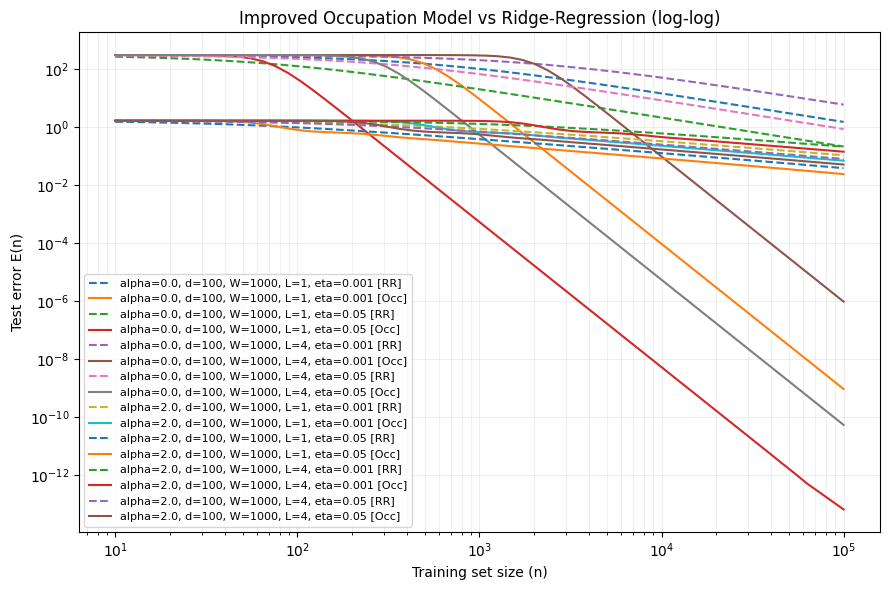

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def teacher_spectrum(k, alpha):
    """
    Teacher 'energy' for mode k. 
    Here we assume sigma_k^2 = 1 / (k+1)^alpha.
    """
    return 1.0 / ((k+1)**alpha)

def ridge_regression_error(n, alpha, kappa, K=300):
    """
    E(n) = sum_{k=1}^K [ sigma_k^2 / ( 1 + (n/kappa)* sigma_k^2 ) ].

    This is the "exact" linear formula for isotropic data 
    with power-law teacher.
    """
    err = 0.0
    for k in range(K):
        sig2 = teacher_spectrum(k, alpha)
        denom = 1.0 + (n/kappa)*sig2
        err += sig2 / denom
    return err

def smooth_occupation_error(n, alpha, kappa, K=300, beta=5.0):
    """
    E(n) = sum_{k=1}^K [ sigma_k^2 * (1 - occ_k(n)) ],

    where occ_k(n) ~ [ (n/kappa)*sigma_k^2 / (1 + (n/kappa)*sigma_k^2 ) ] 
    or equivalently a logistic function. 
    We'll do a logistic approximation:

    n_k = kappa / sigma_k^2
    occ_k(n) = 1 / [1 + exp(-beta (log(n) - log(n_k)))]
    """
    err = 0.0
    for k in range(K):
        sig2 = teacher_spectrum(k, alpha)
        n_k = kappa / sig2  # threshold for mode k
        # logistic occupation
        occ_k = 1.0 / (1.0 + np.exp(-beta*(np.log(n) - np.log(n_k))))
        err += sig2 * (1.0 - occ_k)
    return err

def kappa_function(d, W, L, eta, C0=1.0, gamma_dw=1.0, gamma_L=1.0, gamma_eta=1.0):
    """
    Parametric form for kappa = C0 * (d/W)^gamma_dw * L^gamma_L * (1/eta)^gamma_eta
    """
    return C0 * ((d / W)**gamma_dw) * (L**gamma_L) * (1.0 / (eta**gamma_eta))

def plot_learning_curves(
    alphas, ds, Ws, Ls, etas,
    n_min=10, n_max=1e6, num_points=80,
    K=300,
    C0=1.0, gamma_dw=1.0, gamma_L=1.0, gamma_eta=1.0,
    beta=5.0
):
    """
    Compare ridge_regression_error() and smooth_occupation_error() 
    on a log-log plot for various alphas, etc.
    """
    n_vals = np.logspace(np.log10(n_min), np.log10(n_max), num_points)
    fig, ax = plt.subplots(figsize=(9,6))

    for alpha in alphas:
        for d in ds:
            for W in Ws:
                for L in Ls:
                    for eta in etas:
                        # compute kappa for this set of architecture params
                        kappa_ = kappa_function(d, W, L, eta, C0=C0,
                                               gamma_dw=gamma_dw,
                                               gamma_L=gamma_L,
                                               gamma_eta=gamma_eta)

                        rr_err  = [ridge_regression_error(n, alpha, kappa_, K=K) 
                                   for n in n_vals]
                        occ_err = [smooth_occupation_error(n, alpha, kappa_, K=K, beta=beta) 
                                   for n in n_vals]

                        label_ = f"alpha={alpha}, d={d}, W={W}, L={L}, eta={eta}"
                        ax.loglog(n_vals, rr_err, "--", label=label_+" [RR]")
                        ax.loglog(n_vals, occ_err, "-",  label=label_+" [Occ]")

    ax.set_xlabel("Training set size (n)")
    ax.set_ylabel("Test error E(n)")
    ax.set_title("Improved Occupation Model vs Ridge-Regression (log-log)")
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example usage:
    alphas = [0.0, 2.0]   # small alpha => kink, large alpha => immediate decay
    ds     = [100]
    Ws     = [1000]
    Ls     = [1, 4]
    etas   = [1e-3, 5e-2]

    plot_learning_curves(
        alphas=alphas,
        ds=ds,
        Ws=Ws,
        Ls=Ls,
        etas=etas,
        n_min=10,
        n_max=1e5,
        num_points=60,
        K=300,
        C0=50.0,        # tweak to shift curves
        gamma_dw=0.5,
        gamma_L=1.0,
        gamma_eta=0.5,
        beta=5.0
    )


/tmp/ipykernel_2246188/1851567386.py:100: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


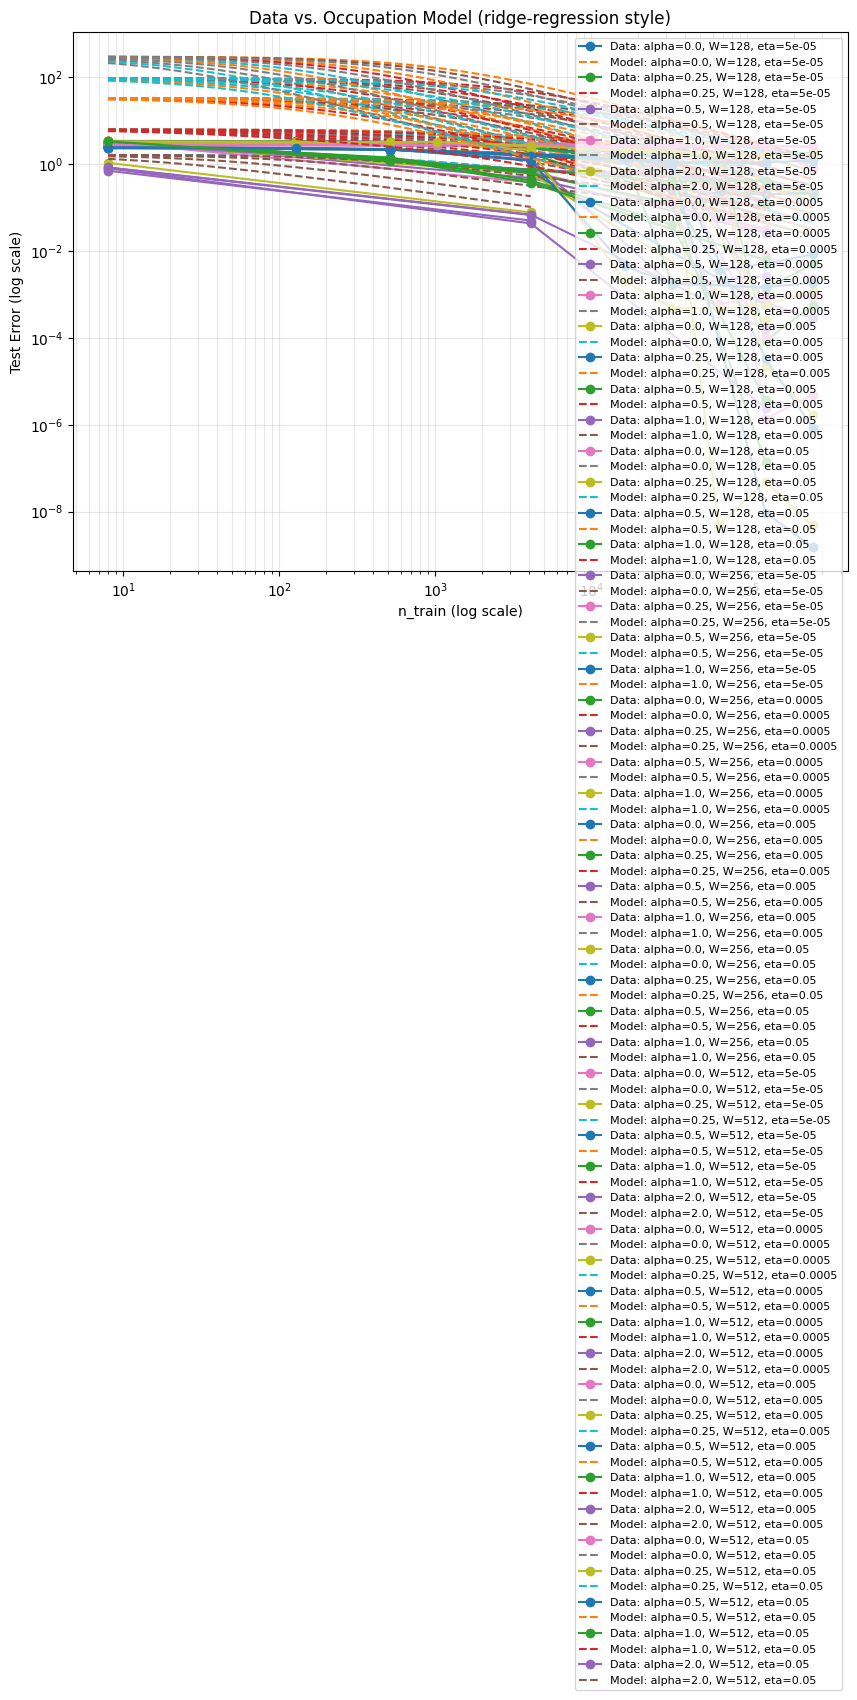

In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt

###############################
# 1) The occupation model
###############################

def teacher_spectrum(k, alpha):
    """sigma_k^2 = 1 / (k+1)^alpha."""
    return 1.0 / ((k+1)**alpha)

def ridge_regression_error(n, alpha, kappa, K=300):
    """
    E(n) = sum_{k=0..K-1} [ sigma_k^2 / (1 + (n/kappa)* sigma_k^2 ) ].
    """
    err = 0.0
    for k in range(K):
        sig2 = teacher_spectrum(k, alpha)
        denom = 1.0 + (n/kappa)*sig2
        err += sig2 / denom
    return err

def kappa_function(W, eta, C0, gamma_w, gamma_eta):
    """
    Parametric form: 
       kappa = C0 * (1/W)^gamma_w * (1/eta)^gamma_eta
    """
    return C0 * (W**(-gamma_w)) * (eta**(-gamma_eta))

def occupation_error(n, alpha, W, eta, C0, gamma_w, gamma_eta, K=300):
    """
    Full model: 
       E(n; alpha, W, eta) = sum_k [ 1/(k+1)^alpha / (1 + (n/kappa)*(1/(k+1)^alpha)) ].
    """
    kappa_ = kappa_function(W, eta, C0, gamma_w, gamma_eta)
    return ridge_regression_error(n, alpha, kappa_, K=K)

###############################
# 2) Example usage / plotting
###############################

# Put your giant JSON data in a file or a variable.
# In this example, let's assume we loaded it into a variable called 'raw_data'.
# If you have it in a local "results.json" file, you can do:
#   with open("results.json") as f:
#       raw_data = json.load(f)

with open("/home/goring/TF_spectrum/plot_data.json") as f:
       raw_data = json.load(f) # <--- Replace with the actual data

# We'll define some guesses for the model exponents:
C0_guess = 100.0
gamma_w_guess = 0.5
gamma_eta_guess = 0.5
K_modes = 300   # how many spectral modes to sum

# We'll create a figure that loops over the different entries in your data.
fig, ax = plt.subplots(figsize=(10, 7))

for entry in raw_data:
    alpha_str = entry["dataset"]  # "a0", "a025", "a05", "a1", "a2"
    # parse alpha from the string
    if alpha_str.startswith("a"):
        # remove 'a' and convert to float
        # watch out for alpha=0.25 => "a025", etc.
        alpha_val = float(alpha_str[1:].replace("05",".5").replace("025",".25"))
    else:
        alpha_val = 0.0

    W = entry["hidden_size"]        # 128, 256, 512
    eta = entry["learning_rate"]     # e.g. 5e-05, ...
    n_train_list = entry["n_train"]
    test_err_list = entry["mean_test_error"]
    
    # Plot the raw data points
    label_data = f"Data: alpha={alpha_val}, W={W}, eta={eta}"
    ax.plot(n_train_list, test_err_list, "o-", label=label_data)
    
    # Now overlay the occupation model
    # We'll evaluate the model on a finer grid in n for a smooth curve
    n_fine = np.logspace(np.log10(min(n_train_list)),
                         np.log10(max(n_train_list)), 100)
    model_err = []
    for n_val in n_fine:
        E_val = occupation_error(n_val, alpha_val, W, eta,
                                 C0_guess, gamma_w_guess, gamma_eta_guess,
                                 K=K_modes)
        model_err.append(E_val)
    label_model = f"Model: alpha={alpha_val}, W={W}, eta={eta}"
    ax.plot(n_fine, model_err, "--", label=label_model)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("n_train (log scale)")
ax.set_ylabel("Test Error (log scale)")
ax.set_title("Data vs. Occupation Model (ridge-regression style)")
ax.grid(True, which="both", alpha=0.3)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()


Fitting failed: too many values to unpack (expected 3)

Fitted parameters:
n0: 10000.000000
gamma: -0.300000
kappa: 1.200000
w0: 1000.000000
delta: 0.500000
zeta: -0.200000
E0: 3.000000
Einf: 0.001000

Parameters saved to fitted_parameters.json


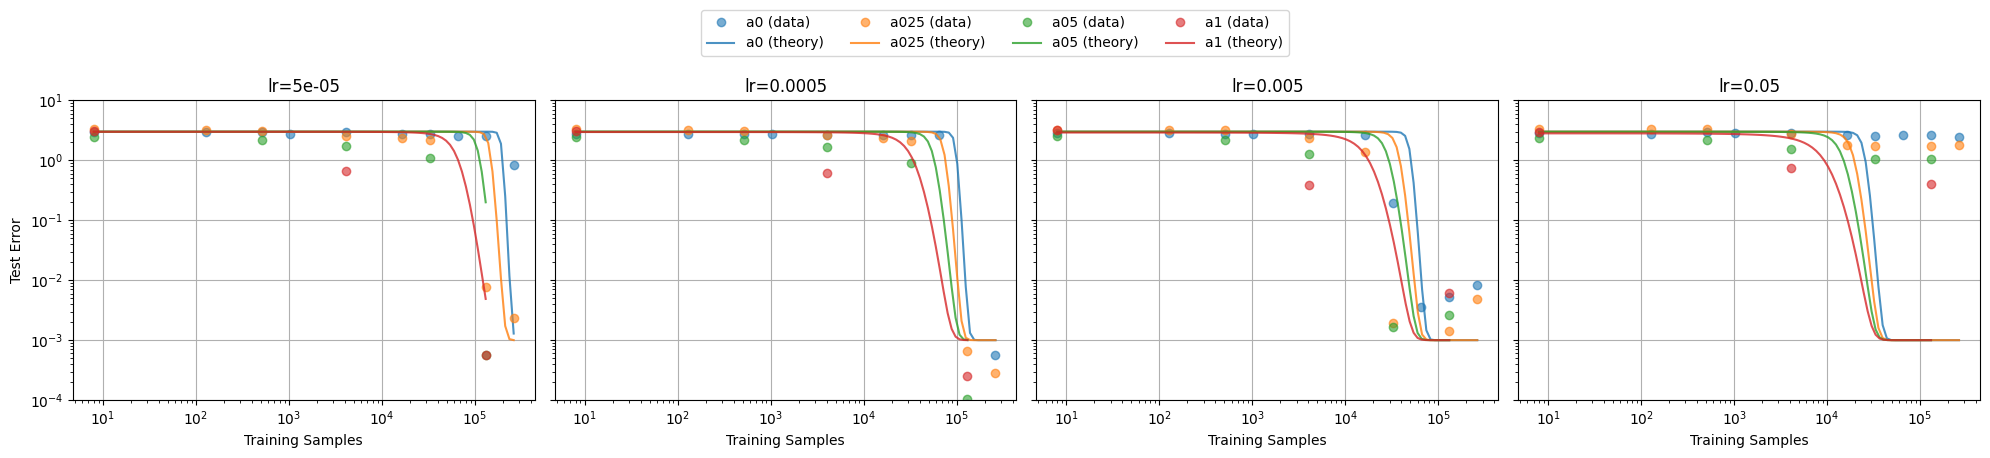

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
from matplotlib.lines import Line2D

def unified_model(n, n0, gamma, kappa, w0, delta, zeta, E0, Einf, alpha, lr):
    """Simplified unified learning model without hidden size dependency."""
    nc = n0 * np.power(lr, gamma) * np.exp(-kappa * alpha)
    w = w0 * (1 + delta * alpha) * np.power(lr, zeta)
    return E0 / (1 + np.exp((n - nc) / w)) + Einf

def get_alpha_from_dataset(dataset_name):
    """Extract alpha value from dataset name."""
    if dataset_name == 'a0':
        return 0.0
    elif dataset_name == 'a025':
        return 0.25
    elif dataset_name == 'a05':
        return 0.5
    elif dataset_name == 'a1':
        return 1.0
    elif dataset_name == 'a2':
        return 2.0
    else:
        raise ValueError(f"Unknown dataset name: {dataset_name}")

def prepare_data_for_fitting(results):
    """Prepare data for parameter fitting, using only h=256."""
    X = []  # Will contain [n, alpha, lr]
    y = []  # Will contain error values
    
    for result in results:
        if result['hidden_size'] != 256:
            continue
            
        alpha = get_alpha_from_dataset(result['dataset'])
        lr = result['learning_rate']
        
        for n, error in zip(result['n_train'], result['mean_test_error']):
            X.append([n, alpha, lr])
            y.append(error)
    
    return np.array(X), np.array(y)

def fit_parameters(results):
    """Fit model parameters to the data."""
    X, y = prepare_data_for_fitting(results)
    
    if len(X) == 0 or len(y) == 0:
        raise ValueError("No data available for fitting!")
    
    # Initial parameter guesses
    p0 = [10000,  # n0
          -0.3,   # gamma (learning rate scaling)
          1.2,    # kappa (alpha coupling)
          1000,   # w0 (base width)
          0.5,    # delta (alpha-width coupling)
          -0.2,   # zeta (lr-width coupling)
          3.0,    # E0 (initial error)
          0.001]  # Einf (final error)
    
    # Define wrapper function for curve_fit
    def fit_func(X, n0, gamma, kappa, w0, delta, zeta, E0, Einf):
        n, alpha, lr = X.T
        return unified_model(n, n0, gamma, kappa, w0, delta, zeta, E0, Einf, alpha, lr)
    
    # Add bounds to ensure physically meaningful parameters
    bounds = ([1e2, -1.0, 0.0, 1e1, 0.0, -1.0, 0.1, 1e-6],  # lower bounds
              [1e6, 0.0, 5.0, 1e4, 2.0, 0.0, 5.0, 0.1])      # upper bounds
    
    # Fit the parameters
    try:
        popt, pcov = curve_fit(fit_func, X.T, y, p0=p0, bounds=bounds, maxfev=10000)
        # Calculate R-squared
        y_pred = fit_func(X.T, *popt)
        r2 = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)
        print(f"R-squared: {r2:.4f}")
        return dict(zip(['n0', 'gamma', 'kappa', 'w0', 'delta', 'zeta', 'E0', 'Einf'], popt))
    except Exception as e:
        print(f"Fitting failed: {e}")
        return dict(zip(['n0', 'gamma', 'kappa', 'w0', 'delta', 'zeta', 'E0', 'Einf'], p0))

def plot_comparison(results, params, save_path=None):
    """Create grid plot comparing theory and data for h=256."""
    # Filter for h=256 and get unique parameters
    results_256 = [r for r in results if r['hidden_size'] == 256]
    learning_rates = sorted(set(r['learning_rate'] for r in results_256))
    datasets = sorted(set(r['dataset'] for r in results_256))
    
    # Create single row of plots, one for each learning rate
    fig, axes = plt.subplots(1, len(learning_rates), figsize=(5 * len(learning_rates), 4), 
                            sharex=True, sharey=True)
    
    # Ensure axes is array
    if len(learning_rates) == 1:
        axes = np.array([axes])
    
    # Colors for different datasets
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    dataset_colors = dict(zip(datasets, colors[:len(datasets)]))
    
    # Plot each learning rate
    for j, lr in enumerate(learning_rates):
        ax = axes[j]
        
        # Plot actual data
        for dataset in datasets:
            relevant_results = [r for r in results_256 
                              if r['learning_rate'] == lr 
                              and r['dataset'] == dataset]
            
            if relevant_results:
                for result in relevant_results:
                    n_train = result['n_train']
                    errors = result['mean_test_error']
                    
                    # Plot data points
                    ax.plot(n_train, errors, 'o', color=dataset_colors[dataset], 
                           label=f'{dataset} (data)', alpha=0.6)
                    
                    # Plot theory curve
                    n_smooth = np.logspace(np.log10(min(n_train)), np.log10(max(n_train)), 100)
                    alpha = get_alpha_from_dataset(dataset)
                    theory = unified_model(n_smooth, **params, alpha=alpha, lr=lr)
                    ax.plot(n_smooth, theory, '-', color=dataset_colors[dataset], 
                           label=f'{dataset} (theory)', alpha=0.8)
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True)
        ax.set_title(f'lr={lr}')
        ax.set_xlabel('Training Samples')
        if j == 0:
            ax.set_ylabel('Test Error')
        
        # Set y-axis limits
        ax.set_ylim(0.0001, 10)
    
    # Add legend
    handles = []
    labels_done = set()
    for dataset in datasets:
        if dataset not in labels_done:
            handles.extend([
                Line2D([0], [0], marker='o', color=dataset_colors[dataset], 
                       label=f'{dataset} (data)', linestyle='none', alpha=0.6),
                Line2D([0], [0], color=dataset_colors[dataset], 
                       label=f'{dataset} (theory)', alpha=0.8)
            ])
            labels_done.add(dataset)
    
    fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15),
              ncol=len(datasets))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    return fig, axes

def main():
    # Load data from JSON file
    with open('/home/goring/TF_spectrum/plot_data.json', 'r') as f:
        results = json.load(f)
    
    # Fit parameters
    params = fit_parameters(results)
    print("\nFitted parameters:")
    for param, value in params.items():
        print(f"{param}: {value:.6f}")
    
    # Create comparison plot
    plot_comparison(results, params, "theory_vs_data.png")
    
    # Save parameters
    with open('fitted_parameters.json', 'w') as f:
        json.dump(params, f, indent=2)
    print("\nParameters saved to fitted_parameters.json")

if __name__ == "__main__":
    main()